# Programmazione di Applicazioni Data Intensive: Progetto 

- Candidato: Fabrizio Margotta
- Dataset: [Malicious and Benign Websites](https://www.kaggle.com/xwolf12/malicious-and-benign-websites) by Christian Urcuqui

## Introduzione

## Analisi esplorativa

In [1]:
# setup e test librerie
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import requests
import io
import seaborn as sns
sns.set();
import sklearn

In [2]:
dtypes = {
    'CHARSET': 'category',
    'SERVER': 'category',
    'WHOIS_COUNTRY': 'category',
    'WHOIS_STATEPRO': 'category',
}

In [3]:
DS_URL = "https://gitlab.com/emrevoid/uni/dia/project/famar/-/raw/master/dataset.csv"
#https://stackoverflow.com/questions/51092889/receiving-http-error-403-forbidden-csv-download/51093473
response = requests.get(DS_URL)
file_object = io.StringIO(response.content.decode('utf-8'))

ds = pd.read_csv(file_object, header=0, index_col=0, sep=';', dtype=dtypes)
ds['WHOIS_REGDATE'] = pd.to_datetime(ds['WHOIS_REGDATE'], errors='coerce')
ds['WHOIS_UPDATED_DATE'] = pd.to_datetime(ds['WHOIS_UPDATED_DATE'], errors='coerce')
ds = ds.rename(columns={"Type": "malicious"})
ds.head()

,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,malicious
URL,,,,,,,,,,,,,,,,,,,,
M0_109,16,7,iso-8859-1,nginx,263.0,None,None,2015-10-10 18:21:00,NaT,7,0,2,700,9,10,1153,832,9,2.0,1
B0_2314,16,6,UTF-8,Apache/2.4.10,15087.0,None,None,NaT,NaT,17,7,4,1230,17,19,1265,1230,17,0.0,0
B0_911,16,6,us-ascii,Microsoft-HTTPAPI/2.0,324.0,None,None,NaT,NaT,0,0,0,0,0,0,0,0,0,0.0,0
B0_113,17,6,ISO-8859-1,nginx,162.0,US,AK,1997-07-10 04:00:00,2013-12-09 00:45:00,31,22,3,3812,39,37,18784,4380,39,8.0,0
B0_403,17,6,UTF-8,None,124140.0,US,TX,1996-12-05 00:00:00,2017-11-04 00:00:00,57,2,5,4278,61,62,129889,4586,61,4.0,0


In [4]:
ds.shape

(1781, 20)

In [5]:
ds["malicious"].value_counts()

0    1565
1     216
Name: malicious, dtype: int64

In [6]:
ds["malicious"].value_counts(normalize=True)

0    0.87872
1    0.12128
Name: malicious, dtype: float64

In [7]:
pd.set_option('display.max_rows', None)
ds.groupby('malicious')['SERVER'].value_counts()

malicious  SERVER                                                                                                                                                                     
0          Apache                                                                                                                                                                         295
           None                                                                                                                                                                           175
           nginx                                                                                                                                                                          162
           Microsoft-HTTPAPI/2.0                                                                                                                                                          110
           cloudflare-nginx                              

In [8]:
ds['CHARSET'].unique()
ds['CHARSET']=np.where(ds['CHARSET'] == 'iso-8859-1', 'ISO-8859-1', ds['CHARSET'])
ds['CHARSET']=np.where(ds['CHARSET'] == 'ISO-8859', 'ISO-8859-1', ds['CHARSET'])
ds['CHARSET']=np.where(ds['CHARSET'] == 'utf-8', 'UTF-8', ds['CHARSET'])

In [9]:
ds['WHOIS_COUNTRY'].unique()
ds['WHOIS_COUNTRY']=np.where(ds['WHOIS_COUNTRY'] == 'United Kingdom', 'UK', ds['WHOIS_COUNTRY'])
ds['WHOIS_COUNTRY']=np.where(ds['WHOIS_COUNTRY'] == "[u'GB', u'UK']", 'UK', ds['WHOIS_COUNTRY'])
ds['WHOIS_COUNTRY']=np.where(ds['WHOIS_COUNTRY'] == 'United Kingdom', 'UK', ds['WHOIS_COUNTRY'])
ds['WHOIS_COUNTRY']=np.where(ds['WHOIS_COUNTRY'] == 'us', 'US', ds['WHOIS_COUNTRY'])
ds['WHOIS_COUNTRY']=np.where(ds['WHOIS_COUNTRY'] == 'se', 'SE', ds['WHOIS_COUNTRY'])
ds['WHOIS_COUNTRY']=np.where(ds['WHOIS_COUNTRY'] == 'ru', 'RU', ds['WHOIS_COUNTRY'])

In [10]:
pd.set_option('display.max_rows', None)
ds.groupby('malicious')['CHARSET'].value_counts()

malicious  CHARSET     
0          UTF-8           903
           ISO-8859-1      504
           us-ascii        151
           None              6
           windows-1252      1
1          UTF-8           152
           ISO-8859-1       58
           us-ascii          4
           None              1
           windows-1251      1
Name: CHARSET, dtype: int64

In [11]:
pd.set_option('display.max_rows', None)
ds.groupby('malicious')['WHOIS_COUNTRY'].value_counts()

malicious  WHOIS_COUNTRY
0          US               1056
           None              241
           CA                 82
           AU                 35
           PA                 19
           GB                 15
           UK                 15
           JP                 11
           IN                  9
           FR                  8
           CN                  7
           CH                  6
           NL                  6
           AT                  4
           BS                  4
           PH                  4
           SE                  4
           BE                  3
           HK                  3
           KR                  3
           KY                  3
           SC                  3
           TR                  3
           Cyprus              2
           DE                  2
           IL                  2
           KG                  2
           NO                  2
           SI                  2
           AE     

In [12]:
pd.set_option('display.max_rows', None)
ds.groupby('malicious')['WHOIS_STATEPRO'].value_counts()

malicious  WHOIS_STATEPRO      
0          CA                      369
           None                    290
           NY                       75
           WA                       63
           FL                       60
           Arizona                  56
           California               45
           ON                       43
           NV                       30
           UT                       29
           CO                       23
           MA                       21
           PA                       20
           IL                       19
           PANAMA                   17
           MO                       15
           NJ                       15
           Ohio                     15
           Queensland               14
           New York                 11
           TX                       10
           VA                       10
           Quebec                    9
           Texas                     9
           DC                   

In [13]:
ds.describe()

,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CONTENT_LENGTH,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,malicious
count,1781.000000,1781.000000,969.000000,1781.000000,1781.000000,1781.000000,1.781000e+03,1781.000000,1781.000000,1.781000e+03,1.781000e+03,1781.000000,1780.000000,1781.000000
mean,56.961258,11.111735,11726.927761,16.261089,5.472768,3.060640,2.982339e+03,18.540146,18.746210,1.589255e+04,3.155599e+03,18.540146,2.263483,0.121280
std,27.555586,4.549896,36391.809051,40.500975,21.807327,3.386975,5.605057e+04,41.627173,46.397969,6.986193e+04,5.605378e+04,41.627173,2.930853,0.326544
min,16.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
25%,39.000000,8.000000,324.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
50%,49.000000,10.000000,1853.000000,7.000000,0.000000,2.000000,6.720000e+02,8.000000,9.000000,5.790000e+02,7.350000e+02,8.000000,0.000000,0.000000
75%,68.000000,13.000000,11323.000000,22.000000,5.000000,5.000000,2.328000e+03,26.000000,25.000000,9.806000e+03,2.701000e+03,26.000000,4.000000,0.000000
max,249.000000,43.000000,649263.000000,1194.000000,708.000000,17.000000,2.362906e+06,1198.000000,1284.000000,2.060012e+06,2.362906e+06,1198.000000,20.000000,1.000000


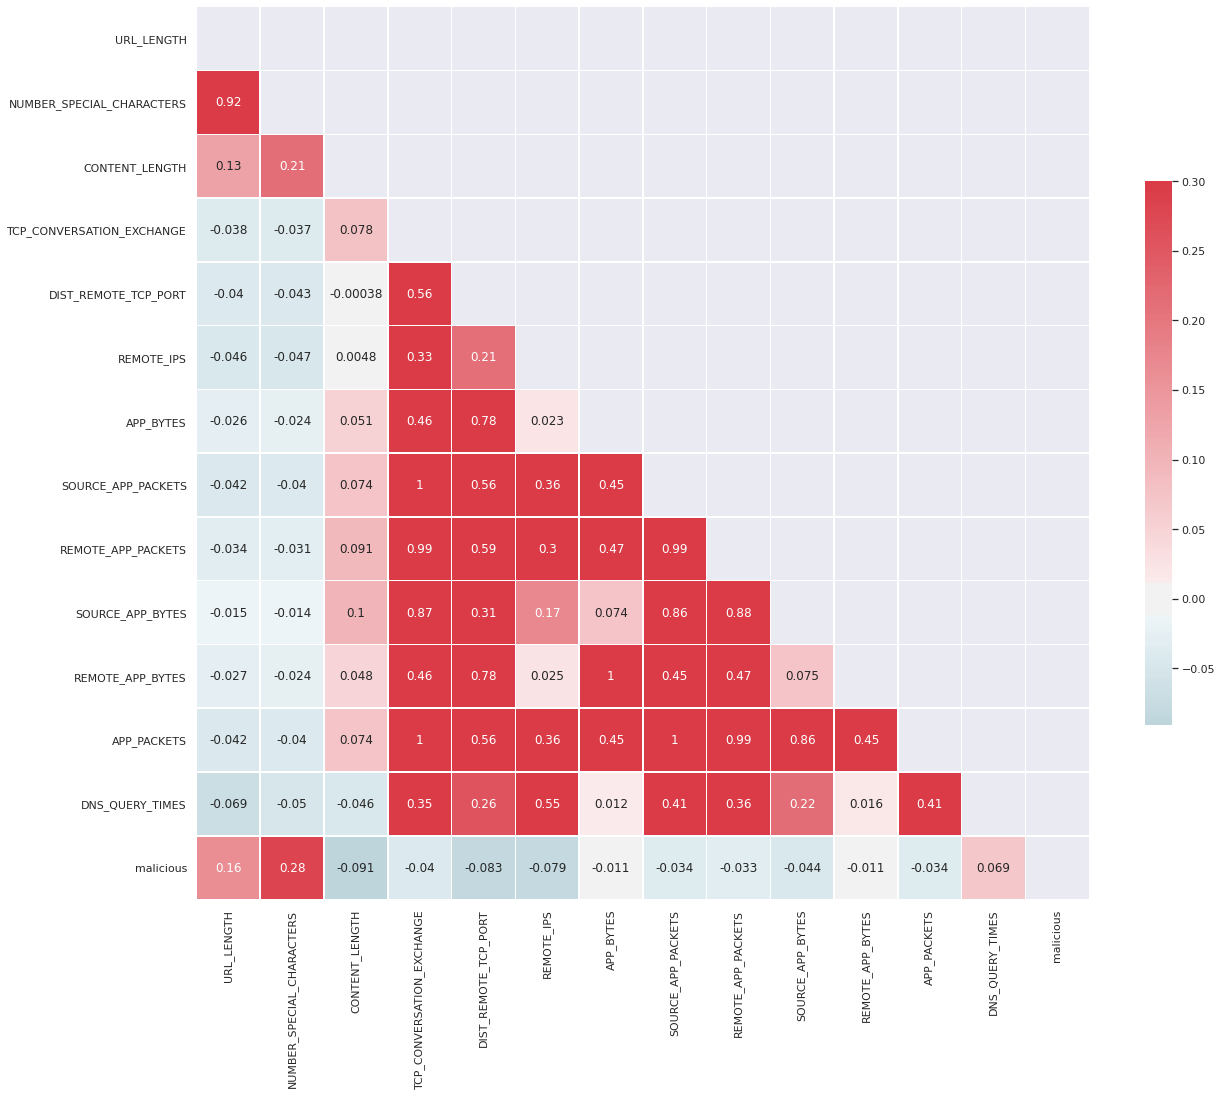

In [14]:
# Compute the correlation matrix
corr = ds.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True);

In [15]:
ds.nunique()

URL_LENGTH                   142
NUMBER_SPECIAL_CHARACTERS     31
CHARSET                        6
SERVER                       239
CONTENT_LENGTH               637
WHOIS_COUNTRY                 44
WHOIS_STATEPRO               182
WHOIS_REGDATE                888
WHOIS_UPDATED_DATE           593
TCP_CONVERSATION_EXCHANGE    103
DIST_REMOTE_TCP_PORT          66
REMOTE_IPS                    18
APP_BYTES                    825
SOURCE_APP_PACKETS           113
REMOTE_APP_PACKETS           116
SOURCE_APP_BYTES             885
REMOTE_APP_BYTES             822
APP_PACKETS                  113
DNS_QUERY_TIMES               10
malicious                      2
dtype: int64

In [16]:
ds['SERVER'].value_counts()[:15]

Apache                    386
nginx                     211
None                      175
Microsoft-HTTPAPI/2.0     113
cloudflare-nginx           94
Microsoft-IIS/7.5          51
GSE                        49
Server                     49
YouTubeFrontEnd            42
nginx/1.12.0               36
ATS                        30
Apache/2.2.15 (CentOS)     25
Apache-Coyote/1.1          20
Microsoft-IIS/8.5          15
Apache/2                   15
Name: SERVER, dtype: int64

Riduciamo la dimensionalità della variabile categorica `SERVER`:

In [17]:
ds['SERVER'] = np.where(ds['SERVER'].str.contains('Apache/'), 'Apache', ds['SERVER'])
ds['SERVER'] = np.where(ds['SERVER'].str.contains('nginx/'), 'nginx', ds['SERVER'])
ds['SERVER'] = np.where(ds['SERVER'].str.contains('Microsoft-'), 'Microsoft', ds['SERVER'])

In [18]:
ds['SERVER'].value_counts()[:3]

Apache       623
nginx        337
Microsoft    198
Name: SERVER, dtype: int64

In [37]:
tmp = ds[ds['SERVER'].isin(ds.SERVER.value_counts()[3:].index)] # OK!
ds[ds['SERVER'].isin(ds.SERVER.value_counts()[3:].index)]

,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,malicious
URL,,,,,,,,,,,,,,,,,,,,
B0_403,17,6,UTF-8,None,124140.0,US,TX,1996-12-05 00:00:00,2017-11-04 00:00:00,57,2,5,4278,61,62,129889,4586,61,4.0,0
B0_22,20,7,UTF-8,None,13716.0,GB,None,2002-11-10 00:00:00,2016-06-10 00:00:00,16,6,8,1492,20,20,2334,1784,20,4.0,0
B0_161,22,6,UTF-8,openresty/1.11.2.1,NaN,US,CA,1999-03-07 00:00:00,2015-07-08 00:00:00,39,29,6,3833,43,42,22495,4125,43,4.0,0
B0_1412,23,7,ISO-8859-1,Oracle-iPlanet-Web-Server/7.0,3257.0,None,None,2000-10-13 00:00:00,2017-04-27 00:00:00,0,0,0,0,0,0,0,0,0,0.0,0
B0_2217,23,6,ISO-8859-1,None,6748.0,US,Arizona,1999-12-31 00:00:00,2017-09-04 00:00:00,7,4,5,630,7,4,244,630,7,0.0,0
B0_23,23,6,None,None,NaN,US,TX,1996-07-30 00:00:00,2016-04-07 00:00:00,19,7,6,2404,23,20,6179,2684,23,4.0,0
B0_241,23,6,UTF-8,None,NaN,GB,None,2008-09-05 00:00:00,2015-11-27 00:00:00,19,14,6,1980,23,25,5737,2276,23,4.0,0
B0_285,23,6,UTF-8,None,NaN,US,WI,1999-04-23 00:00:00,2016-07-25 00:00:00,4,0,1,519,8,8,1138,823,8,4.0,0
B0_465,23,6,UTF-8,cloudflare-nginx,NaN,US,Oregon,1997-04-02 00:00:00,2014-08-11 00:00:00,10,0,5,1186,14,15,1900,1476,14,4.0,0


In [38]:
tmp['malicious'].value_counts()

0    611
1     12
Name: malicious, dtype: int64

In [39]:
tmp.shape

(623, 20)

In [40]:
tmp2 = ds[ds['SERVER'].isin(ds.SERVER.value_counts()[:3].index)] # OK!
tmp2['malicious'].value_counts()

0    954
1    204
Name: malicious, dtype: int64

In [41]:
tmp2.shape

(1158, 20)

In [42]:
ds = ds.drop(ds[ds['SERVER'].isin(ds.SERVER.value_counts()[3:].index)].index) # FATTO
ds

,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,malicious
URL,,,,,,,,,,,,,,,,,,,,
M0_109,16,7,ISO-8859-1,nginx,263.0,None,None,2015-10-10 18:21:00,NaT,7,0,2,700,9,10,1153,832,9,2.0,1
B0_2314,16,6,UTF-8,Apache,15087.0,None,None,NaT,NaT,17,7,4,1230,17,19,1265,1230,17,0.0,0
B0_911,16,6,us-ascii,Microsoft,324.0,None,None,NaT,NaT,0,0,0,0,0,0,0,0,0,0.0,0
B0_113,17,6,ISO-8859-1,nginx,162.0,US,AK,1997-07-10 04:00:00,2013-12-09 00:45:00,31,22,3,3812,39,37,18784,4380,39,8.0,0
B0_2064,18,7,UTF-8,nginx,NaN,SC,Mahe,2016-03-08 14:30:00,2016-03-10 03:45:00,11,6,9,894,11,13,838,894,11,0.0,0
B0_462,18,6,ISO-8859-1,Apache,345.0,US,CO,2002-07-29 00:00:00,2016-01-07 00:00:00,12,0,3,1189,14,13,8559,1327,14,2.0,0
B0_1128,19,6,us-ascii,Microsoft,324.0,US,FL,1997-03-18 00:00:00,2017-03-19 00:00:00,0,0,0,0,0,0,0,0,0,0.0,0
M2_17,20,5,UTF-8,nginx,NaN,None,None,2014-08-11 07:41:00,NaT,0,0,0,0,2,3,213,146,2,2.0,1
M3_75,20,5,UTF-8,nginx,NaN,None,None,2014-08-11 07:41:00,NaT,0,0,0,0,2,1,62,146,2,2.0,1


In [43]:
ds['malicious'].value_counts()

0    954
1    204
Name: malicious, dtype: int64

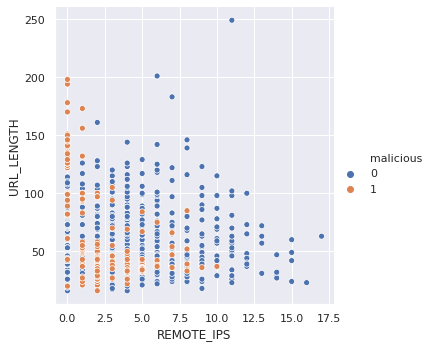

In [44]:
ordered = ds.sort_values('malicious')
sns.relplot(x="REMOTE_IPS", y="URL_LENGTH", hue="malicious", data=ordered);

In [45]:
features = ['URL_LENGTH', 'NUMBER_SPECIAL_CHARACTERS', 'APP_BYTES']

Rimozione di valori fuori "scala" che non permettono di visualizzare correttamente alcuni scatterplot (poiché "appiattiscono" la distribuzione).

In [46]:
ds = ds.drop(ds.index[ds.APP_BYTES > 40000])
ds.sort_values('APP_BYTES')['APP_BYTES']

URL
M4_13          0
B0_822         0
B0_1122        0
B0_1245        0
B0_1286        0
B0_1294        0
B0_1305        0
B0_1208        0
B0_1340        0
B0_1263        0
B0_1253        0
B0_1183        0
B0_913         0
B0_949         0
M4_68          0
B0_819         0
B0_1046        0
M4_17          0
B0_1134        0
B0_1140        0
B0_1192        0
B0_1232        0
B0_1262        0
B0_1272        0
B0_1318        0
M4_7           0
M4_12          0
M4_10          0
B0_1201        0
B0_1220        0
B0_1221        0
B0_1333        0
B0_1397        0
M4_11          0
B0_1063        0
B0_1089        0
B0_1151        0
B0_1423        0
B0_1004        0
M4_27          0
B0_789         0
B0_797         0
B0_843         0
B0_1370        0
B0_861         0
B0_907         0
B0_975         0
B0_785         0
B0_1160        0
B0_1186        0
B0_1346        0
B0_898         0
B0_1088        0
B0_974         0
B0_821         0
B0_1170        0
B0_1259        0
B0_1323        0
B0_1392   

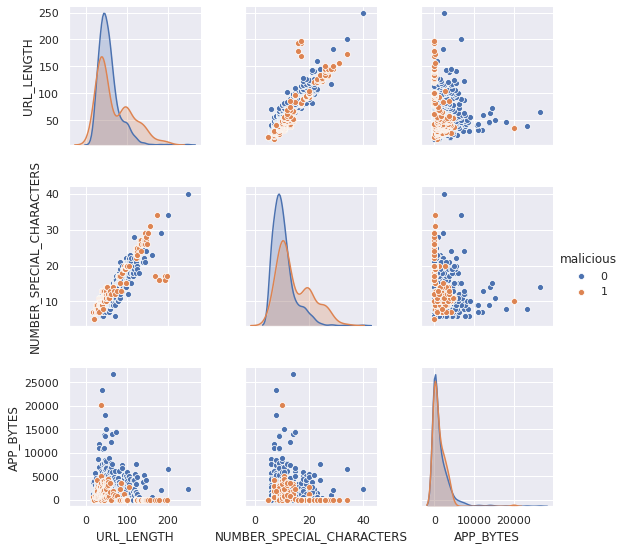

In [47]:
sns.pairplot(data=ds, hue="malicious", vars=features);

## Preparazione del dataset

### Gestione di valori nulli

Verifichiamo che nel dataset siano presenti valori nulli:

In [48]:
ds.isna().sum()

URL_LENGTH                     0
NUMBER_SPECIAL_CHARACTERS      0
CHARSET                        0
SERVER                         0
CONTENT_LENGTH               424
WHOIS_COUNTRY                  0
WHOIS_STATEPRO                 0
WHOIS_REGDATE                114
WHOIS_UPDATED_DATE           124
TCP_CONVERSATION_EXCHANGE      0
DIST_REMOTE_TCP_PORT           0
REMOTE_IPS                     0
APP_BYTES                      0
SOURCE_APP_PACKETS             0
REMOTE_APP_PACKETS             0
SOURCE_APP_BYTES               0
REMOTE_APP_BYTES               0
APP_PACKETS                    0
DNS_QUERY_TIMES                1
malicious                      0
dtype: int64

Usiamo il metodo `.fillna()`:
- per le feature numeriche sostituiamo i valori nulli con le medie

In [49]:
ds['CONTENT_LENGTH'].fillna(ds['CONTENT_LENGTH'].mean(), inplace=True)
ds['DNS_QUERY_TIMES'].fillna(ds['DNS_QUERY_TIMES'].mean(), inplace=True)

- per le feature temporali (`WHOIS_REGDATE` e `WHOIS_UPDATED_DATE`) usiamo i parametri `ffill` o `bfill`

In [50]:
ds['WHOIS_REGDATE'].fillna(method="ffill", inplace=True)
ds['WHOIS_UPDATED_DATE'].fillna(method="ffill", inplace=True)
ds['WHOIS_UPDATED_DATE'].fillna(method="bfill", inplace=True)

Verifichiamo di aver risolto il problema dei valori nulli:

In [51]:
ds.isna().sum()

URL_LENGTH                   0
NUMBER_SPECIAL_CHARACTERS    0
CHARSET                      0
SERVER                       0
CONTENT_LENGTH               0
WHOIS_COUNTRY                0
WHOIS_STATEPRO               0
WHOIS_REGDATE                0
WHOIS_UPDATED_DATE           0
TCP_CONVERSATION_EXCHANGE    0
DIST_REMOTE_TCP_PORT         0
REMOTE_IPS                   0
APP_BYTES                    0
SOURCE_APP_PACKETS           0
REMOTE_APP_PACKETS           0
SOURCE_APP_BYTES             0
REMOTE_APP_BYTES             0
APP_PACKETS                  0
DNS_QUERY_TIMES              0
malicious                    0
dtype: int64

In [52]:
# X = ds[['URL_LENGTH', 'NUMBER_SPECIAL_CHARACTERS','DNS_QUERY_TIMES']]
X = ds.drop(['CHARSET', 'SERVER', 'WHOIS_COUNTRY', 'WHOIS_STATEPRO', 'WHOIS_REGDATE', 'WHOIS_UPDATED_DATE', 'malicious'], axis=1)
y = ds['malicious']

### Risoluzione problema classi sbilanciate

In [72]:
ds.shape

(1157, 20)

In [68]:
ds["malicious"].value_counts()

0    953
1    204
Name: malicious, dtype: int64

In [53]:
from imblearn.over_sampling import SMOTE
from collections import Counter
X_resampled, y_resampled = SMOTE().fit_resample(X, y)
print(sorted(Counter(y_resampled).items()))

[(0, 953), (1, 953)]


In [54]:
sns.set();
ds_oversampled = pd.concat([X_resampled, y_resampled], axis=1)

In [71]:
ds.shape

(1157, 20)

In [70]:
ds_oversampled["malicious"].value_counts()

1    953
0    953
Name: malicious, dtype: int64

In [55]:
ds_oversampled["malicious"].value_counts(normalize=True)

1    0.5
0    0.5
Name: malicious, dtype: float64

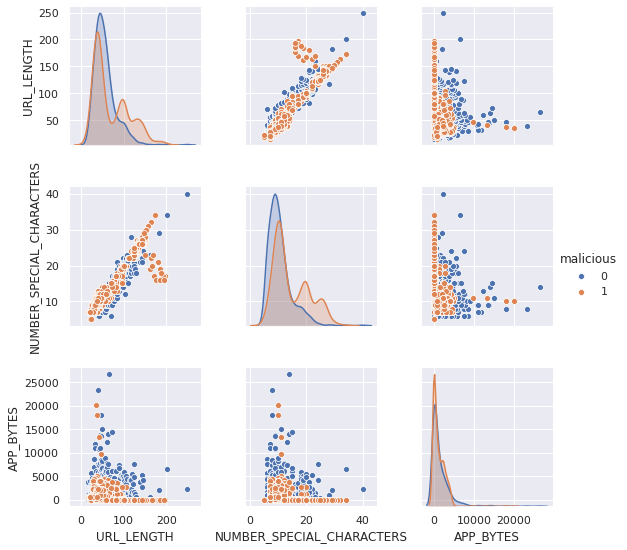

In [56]:
sns.pairplot(data=ds_oversampled, hue="malicious", vars=features);

## Classificazione

Separazione del dataset:

In [57]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_resampled, y_resampled,
    test_size=1/3,
    random_state=42,
)

Stratified K fold: preparazione dell'oggetto:

In [58]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(3, shuffle=True, random_state=42)
for train, val in skf.split(X_train, y_train):
    print(y_train.iloc[val].value_counts())

0    214
1    210
Name: malicious, dtype: int64
0    213
1    210
Name: malicious, dtype: int64
0    214
1    209
Name: malicious, dtype: int64


### Perceptron

Perceptron in pipeline con grid search su Standardizzazione, feature polinomiali (gradi da 1 a 5) e regolarizzazione in un intervallo con 5 valori da 10^-2 a 10^2.

In [60]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Perceptron
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import classification_report

from sklearn.model_selection import GridSearchCV

In [61]:
#    {
#        "std" : scale
#    },
#    {
#        "std" : scale,
#        "poly": polynomial,
#        "poly__degree": polynomial_degree
#    },
#    {
#        "std" : scale,
#        "perceptron__penalty": ["l2", "l1", "elasticnet"],
#        "perceptron__alpha": np.logspace(-2, 2, 5),
#        "poly": polynomial,
#        "poly__degree": polynomial_degree
#    },
#        ("poly", None),
# polynomial_degree = [i for i in range(1, 6)]
# polynomial = [PolynomialFeatures(include_bias=False)]

In [62]:
scale = [None, StandardScaler()]
grid = [
    {
        "std" : scale,
        "perceptron__penalty": ["l2", "l1", "elasticnet"],
        "perceptron__alpha": np.logspace(-2, 2, 5)
    },
]

# Perceptron with standard scaler
model_perceptron = Pipeline([
    ('std', None),
    ('perceptron', Perceptron(random_state=42))
])

gs = GridSearchCV(model_perceptron, grid, cv=skf)
gs.fit(X_train, y_train)

print('Accuracy on train {:.2f}%'.format(gs.score(X_train, y_train)*100))
print('Accuracy on val {:.2f}%'.format(gs.score(X_val, y_val)*100))
print(gs.best_params_)

Accuracy on train 74.88%
Accuracy on val 75.94%
{'perceptron__alpha': 0.01, 'perceptron__penalty': 'l1', 'std': StandardScaler()}


Addestriamo lo stesso modello sui DataFrame contenenti le classi sbilanciate:

In [63]:
X_train_unb, X_val_unb, y_train_unb, y_val_unb = train_test_split(
    X, y,
    test_size=1/3,
    random_state=42,
)

In [64]:
# Perceptron with standard scaler
model_perceptron_unb = Pipeline([
    ('std', None),
    ('perceptron', Perceptron(random_state=42))
])

gs_unb = GridSearchCV(model_perceptron_unb, grid, cv=skf)
gs_unb.fit(X_train_unb, y_train_unb);

In [65]:
print('Accuracy on train {:.2f}%'.format(gs_unb.score(X_train_unb, y_train_unb)*100))
print('Accuracy on val {:.2f}%'.format(gs_unb.score(X_val_unb, y_val_unb)*100))
print(gs_unb.best_params_)

Accuracy on train 86.64%
Accuracy on val 87.31%
{'perceptron__alpha': 0.01, 'perceptron__penalty': 'l1', 'std': StandardScaler()}


#### Matrice di confusione

Calcoliamo la matrice di confusione sia per il DataSet originale con classi sbilanciate che con quello in cui le classi sono state bilanciate tramite SMOTE.

<Figure size 288x216 with 0 Axes>

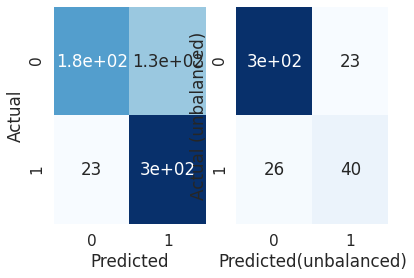

In [73]:
# https://www.kaggle.com/agungor2/various-confusion-matrix-plots#1.-Seaborn-Heatmap-
from sklearn.metrics import confusion_matrix
y_pred = gs.predict(X_val)
data = confusion_matrix(y_val, y_pred)

df_cm = pd.DataFrame(data, columns=np.unique(y_train), index = np.unique(y_train))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (4,3));
sns.set(font_scale=1.4); #for label size
#sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

y_pred_unb = gs_unb.predict(X_val_unb)
data_unb = confusion_matrix(y_val_unb, y_pred_unb)
df_cm_unb = pd.DataFrame(data_unb, columns=np.unique(y_train_unb), index = np.unique(y_train_unb))

# https://stackoverflow.com/questions/42712304/seaborn-heatmap-subplots-keep-axis-ratio-consistent
f,(ax1,ax2) = plt.subplots(1,2);
g1 = sns.heatmap(df_cm, cmap="Blues", annot=True, cbar=False, ax=ax1);
g1.set_ylabel('Actual');
g1.set_xlabel('Predicted');
g2 = sns.heatmap(df_cm_unb, cmap="Blues", annot=True, cbar=False, ax=ax2);
g2.set_ylabel('Actual (unbalanced)');
g2.set_xlabel('Predicted(unbalanced)');

#### Precision e recall

In [74]:
from sklearn.metrics import classification_report

Balanced:

In [75]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.58      0.70       312
           1       0.70      0.93      0.80       324

    accuracy                           0.76       636
   macro avg       0.79      0.76      0.75       636
weighted avg       0.79      0.76      0.75       636



Unbalanced:

In [76]:
print(classification_report(y_val_unb, y_pred_unb))

              precision    recall  f1-score   support

           0       0.92      0.93      0.92       320
           1       0.63      0.61      0.62        66

    accuracy                           0.87       386
   macro avg       0.78      0.77      0.77       386
weighted avg       0.87      0.87      0.87       386



### Regressione logistica

In [78]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import classification_report

from sklearn.model_selection import GridSearchCV

In [ ]:
#    {
#        "std" : scale,
#        "poly": polynomial,
#        "poly__degree": polynomial_degree
#    },
#    {
#        "std" : scale,
#        "logreg__penalty": ["l1"],
#        "logreg__C": np.logspace(-2, 2, 5),
#        "poly": polynomial,
#        "poly__degree": polynomial_degree
#    },
# polynomial = [PolynomialFeatures(include_bias=False)]
# polynomial_degree = [i for i in range(1, 6)]
#     ('poly', None),

In [79]:
scale = [None, StandardScaler()]
grid = [
    {
        "std" : scale,
        "logreg__penalty": ["l1"],
        "logreg__C": np.logspace(-2, 2, 5)
    },
]

# Perceptron with standard scaler
model_logreg = Pipeline([
    ('std', None),
    ('logreg', LogisticRegression(solver="saga", dual=False, random_state=42))
])

gs_logreg = GridSearchCV(model_logreg, grid, cv=skf)
gs_logreg.fit(X_train, y_train)

print('Accuracy on train {:.2f}%'.format(gs_logreg.score(X_train, y_train)*100))
print('Accuracy on val {:.2f}%'.format(gs_logreg.score(X_val, y_val)*100))
print(gs_logreg.best_params_)

/home/famar/.local/share/virtualenvs/di-project-8NWtbAsw/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/famar/.local/share/virtualenvs/di-project-8NWtbAsw/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/famar/.local/share/virtualenvs/di-project-8NWtbAsw/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/famar/.local/share/virtualenvs/di-project-8NWtbAsw/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The

Accuracy on train 83.15%
Accuracy on val 84.12%
{'logreg__C': 10.0, 'logreg__penalty': 'l1', 'std': StandardScaler()}


/home/famar/.local/share/virtualenvs/di-project-8NWtbAsw/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [80]:
y_pred = gs_logreg.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.81      0.83       312
           1       0.83      0.87      0.85       324

    accuracy                           0.84       636
   macro avg       0.84      0.84      0.84       636
weighted avg       0.84      0.84      0.84       636



#### Differenza tra i modelli

In [81]:
def diff_interval(a1, a2, N1, N2, Z):
    sigma1 = a1 * (1 - a1) / N1
    sigma2 = a2 * (1 - a2) / N2
    sigma = np.sqrt(sigma1 + sigma2)
    diff = abs(a1 - a2)
    Z_sigma = Z * sigma
    return (diff - Z_sigma, diff + Z_sigma)

In [82]:
from scipy.stats import norm
def model_diff_interval(m1, m2, X, y, level=0.95):
    a1 = m1.score(X, y)
    a2 = m2.score(X, y)
    N1 = len(X)
    N2 = len(X)
    Z = norm.ppf((1 + level) / 2)
    return diff_interval(a1, a2, N1, N2, Z)

In [83]:
model_diff_interval(gs, gs_unb, X_val, y_val)

(-0.03071146831938506, 0.062158009199888196)